make sure to shut down all kernels and restart the kernel if we rerun to avoid access errors

#### Part I- taken from py_scheduled_action_commands.ipynb

In [1]:
import time

from arena_api.system import system

In [2]:
#extra imports from acquisition single buffer gui
import time

import numpy as np # pip3 install numpy
import cv2  # pip3 install opencv-python
from matplotlib import pyplot as plt # pip3 install matplotlib

from arena_api import enums
from arena_api.buffer import BufferFactory

In [3]:
#extra imports from py_save
from datetime import datetime

from arena_api.enums import PixelFormat
from arena_api.__future__.save import Writer


#### Scheduled Action Commands
> This example introduces scheduling action commands on multiple cameras. The device settings are configured to allow each device to trigger a single image using action commands. The system is prepared to receive an action command and the devices' PTP relationships are synchronized. This allows actions commands to be fired across all devices, resulting in simultaneously acquired images with synchronized timestamps. Depending on the initial PTP state of each camera, it can take about 40 seconds for all devices to autonegotiate.

In [4]:
TAB1 = "  "
TAB2 = "    "
# Exposure time to set in microseconds
EXPOSURE_TIME_TO_SET_US = 500.0
# Delta time in nanoseconds to set action command
DELTA_TIME_NS = 1000000000
# Creating global system nodemap
sys_tl_map = system.tl_system_nodemap

## Create Devices & Initialize attributes

In [5]:
"""
This function will let users know that a device is needed and
gives them a chance to connect a device instead of raising an exception
"""
tries = 0
tries_max = 6
sleep_time_secs = 10
while tries < tries_max:  # Wait for device for 60 seconds
    devices = system.create_device() #obtain list of cameras
    if not devices:
        print(
            f'Try {tries+1} of {tries_max}: waiting for {sleep_time_secs}'
            f'secs for a device to be connected!')
        for sec_count in range(sleep_time_secs):
            time.sleep(1)
            print(f'{sec_count + 1 } seconds passed ',
                    '.' * sec_count, end='\r')
        tries += 1
    else:
        break
else:
    raise Exception(f'No device found! Please connect a device and run '
                    f'the example again.')


In [6]:
def store_initial(device):
    '''
    obtains initial attributes to restore them back after sync
    '''
    dev_map = device.nodemap
    exposure_auto_initial = dev_map['ExposureAuto'].value
    trigger_source_initial = dev_map['TriggerSource'].value
    action_uncond_initial = dev_map['ActionUnconditionalMode'].value
    action_selector_initial = dev_map['ActionSelector'].value
    action_group_key_initial = dev_map['ActionGroupKey'].value
    action_group_mask_initial = dev_map['ActionGroupMask'].value
    transfer_control_mode_initial = dev_map['TransferControlMode'].value
    ptp_enable_initial = dev_map['PtpEnable'].value
    action_command_dev_key_initial = sys_tl_map['ActionCommandDeviceKey'].value
    action_command_grp_key_initial = sys_tl_map['ActionCommandGroupKey'].value
    action_command_grp_mask_initial = sys_tl_map['ActionCommandGroupMask'].value
    action_command_target_ip_initial = sys_tl_map['ActionCommandTargetIP'].value
    
    #new
    #pixel_format_initial = dev_map['PixelFormat'].value

    return [ exposure_auto_initial, trigger_source_initial, action_uncond_initial, 
    action_selector_initial, action_group_key_initial, action_group_mask_initial,
    transfer_control_mode_initial, ptp_enable_initial,
    action_command_dev_key_initial, action_command_grp_key_initial, 
    action_command_grp_mask_initial, action_command_target_ip_initial]

In [7]:
def restore_initial(initial_vals, device):
    dev_map = device.nodemap

    dev_map['ExposureAuto'].value = initial_vals[0]
    dev_map['TriggerSource'].value = initial_vals[1]
    dev_map['ActionUnconditionalMode'].value = initial_vals[2]
    dev_map['ActionSelector'].value = initial_vals[3]
    dev_map['ActionGroupKey'].value = initial_vals[4]
    dev_map['ActionGroupMask'].value = initial_vals[5]
    dev_map['TransferControlMode'].value = initial_vals[6]
    dev_map['PtpEnable'].value = initial_vals[7]
    sys_tl_map['ActionCommandDeviceKey'].value = initial_vals[8]
    sys_tl_map['ActionCommandGroupKey'].value = initial_vals[9]
    sys_tl_map['ActionCommandGroupMask'].value = initial_vals[10]
    sys_tl_map['ActionCommandTargetIP'].value = initial_vals[11]
    
    #dev_map['PixelFormat'].value = initial_vals[12]

## Print Devices

In [8]:
"""
Use max supported packet size. We use transfer control to ensure that
only one camera is transmitting at a time.
"""
print(devices)
for device in devices:
    device.tl_stream_nodemap['StreamAutoNegotiatePacketSize'].value = True

print(f'{TAB1}Stream Auto Negotiate Packet Size Enabled :'
        f''' {device.tl_stream_nodemap['StreamAutoNegotiatePacketSize'].value}''')

[<arena_api._device.Device object at 0x000002322EE12308>, <arena_api._device.Device object at 0x000002322EE12788>, <arena_api._device.Device object at 0x000002322E4BE8C8>, <arena_api._device.Device object at 0x000002322EE08CC8>, <arena_api._device.Device object at 0x000002327FBFBBC8>, <arena_api._device.Device object at 0x000002322EDC5E08>]
  Stream Auto Negotiate Packet Size Enabled : True


In [9]:
'''
Set the colors

# Setting pixel format 
new_pixel_format = 'Mono8'
for device in devices:
    dev_map = device.nodemap
    print(f'Setting \'PixelFormat\' to \'{new_pixel_format}\'')
    dev_map['PixelFormat'].value = new_pixel_format
'''

"\nSet the colors\n\n# Setting pixel format \nnew_pixel_format = 'Mono8'\nfor device in devices:\n    dev_map = device.nodemap\n    print(f'Setting 'PixelFormat' to '{new_pixel_format}'')\n    dev_map['PixelFormat'].value = new_pixel_format\n"

In [10]:
"""
Manually set exposure time
    In order to get synchronized images, the exposure time
    must be synchronized.
"""
dev_map = device.nodemap
nodes = dev_map.get_node(['ExposureAuto', 'ExposureTime'])

nodes['ExposureAuto'].value = 'Off'

exposure_time_node = nodes['ExposureTime']

min_device_exposure_time = exposure_time_node.min
max_device_exposure_time = exposure_time_node.max

if (EXPOSURE_TIME_TO_SET_US >= min_device_exposure_time and
        EXPOSURE_TIME_TO_SET_US <= max_device_exposure_time):
    exposure_time_node.value = EXPOSURE_TIME_TO_SET_US
else:
    exposure_time_node.value = min_device_exposure_time

print(f'''{TAB1}Exposure Time : {dev_map['ExposureTime'].value}''')

  Exposure Time : 495.288


In [11]:
"""
Enable trigger mode and set source to action
To trigger a single image using action commands, trigger mode must
be enabled, the source set to an action command, and the selector
set to the start of a frame.
"""
for device in devices:
    dev_map = device.nodemap

    dev_map['TriggerMode'].value = 'On'
    dev_map['TriggerSource'].value = 'Action0'
    dev_map['TriggerSelector'].value = 'FrameStart'

print(f'''{TAB1}Trigger Source : {dev_map['TriggerSource'].value}''')

  Trigger Source : Action0


In [12]:
"""
Prepare the device to receive an action command
Action unconditional mode allows a camera to accept action from an
application without write access. The device key, group key, and
group mask must match similar settings in the system's TL node map.
"""
for device in devices:
    dev_map = device.nodemap

    dev_map['ActionUnconditionalMode'].value = 'On'
    dev_map['ActionSelector'].value = 0
    dev_map['ActionDeviceKey'].value = 1
    dev_map['ActionGroupKey'].value = 1
    dev_map['ActionGroupMask'].value = 1

print(f'{TAB1}Action commands: prepared')

  Action commands: prepared


In [13]:
"""
Enable user controlled transfer control
Synchronized cameras will begin transmiting images at the same time.
To avoid missing packets due to collisions, we will use transfer
control to control when each camera transmits the image.
"""
for device in devices:
    dev_map = device.nodemap

    dev_map['TransferControlMode'].value = 'UserControlled'
    dev_map['TransferOperationMode'].value = 'Continuous'
    dev_map['TransferStop'].execute()

print(f'{TAB1}Transfer Control: prepared')

  Transfer Control: prepared


#### Negotiate master/slave

In [14]:
"""
Synchronize devices by enabling PTP
Enabling PTP on multiple devices causes them to negotiate amongst
themselves so that there is a single master device while all the
rest become slaves. The slaves' clocks all synchronize to the
master's clock.
"""
for device in devices:
    device.nodemap['PtpEnable'].value = True

print(f'''{TAB1}PTP Enabled : {device.nodemap['PtpEnable'].value}\n''')

  PTP Enabled : True



In [15]:
"""
Prepare the system to broadcast an action command.
The device key, group key, group mask, and target IP must all match
similar settings in the devices' node maps. The target IP acts as a mask.
"""
sys_tl_map['ActionCommandDeviceKey'].value = 1
sys_tl_map['ActionCommandGroupKey'].value = 1
sys_tl_map['ActionCommandGroupMask'].value = 1
sys_tl_map['ActionCommandTargetIP'].value = 0xFFFFFFFF  # 0.0.0.0

print(f'{TAB1}System: prepared')

  System: prepared


# Synchronize Cameras
#### chooses a master and rest are slaves

In [16]:
def synchronize_cameras():
    """
    Wait for devices to negotiate their PTP relationship
    Before starting any PTP-dependent actions, it is important to
    wait for the devices to complete their negotiation; otherwise,
    the devices may not yet be synced. Depending on the initial PTP
    state of each camera, it can take about 40 seconds for all devices
    to autonegotiate. Below, we wait for the PTP status of each device until
    there is only one 'Master' and the rest are all 'Slaves'.
    During the negotiation phase, multiple devices may initially come up as
    Master so we will wait until the ptp negotiation completes.
    """
    print(f'{TAB1}Waiting for PTP Master/Slave negotiation. '
          f'This can take up to about 40s')

    while True:
        master_found = False
        restart_sync_check = False

        for device in devices:

            ptp_status = device.nodemap['PtpStatus'].value

            # User might uncomment this line for debugging
            '''
            print(f'{device} is {ptp_status}')
            '''

            # Find master
            if ptp_status == 'Master':
                if master_found:
                    restart_sync_check = True
                    break
                master_found = True

            # Restart check until all slaves found
            elif ptp_status != 'Slave':
                restart_sync_check = True
                break

        # A single master was found and all remaining cameras are slaves
        if not restart_sync_check and master_found:
            break

        time.sleep(1)


In [17]:
#function from acquisition_single_buffer_gui
def convert_buffer_to_BGR8(buffer):

    if (buffer.pixel_format == enums.PixelFormat.BGR8):
        return buffer
    print('Converting image buffer pixel format to BGR8 ')
    return BufferFactory.convert(buffer, enums.PixelFormat.BGR8) #must be destroyed after

This version of schedule action commands plots all images on one matplotlib figure

In [18]:
def schedule_action_command():
    """
    Set up timing and broadcast action command
    Action commands must be scheduled for a time in the future.
    This can be done by grabbing the PTP time from a device, adding
    a delta to it, and setting it as an action command's execution time.
    """
    device = devices[0]
    imgs = []

    device.nodemap['PtpDataSetLatch'].execute()
    ptp_data_set_latch_value = device.nodemap['PtpDataSetLatchValue'].value

    print(f'{TAB2}Set action command to {DELTA_TIME_NS} nanoseconds from now')

    sys_tl_map['ActionCommandExecuteTime'].value \
        = ptp_data_set_latch_value + DELTA_TIME_NS

    print(f'{TAB2}Fire action command')
    """
    Fire action command
    Action commands are fired and broadcast to all devices, but
    only received by the devices matching desired settings.
    """
    sys_tl_map['ActionCommandFireCommand'].execute()

    # Grab image from cameras
    for device in devices:

        # Transfer Control
        device.nodemap['TransferStart'].execute()

        buffer = device.get_buffer(timeout=2000)

        device.nodemap['TransferStop'].execute()
        
        print(f'{TAB1}{TAB2}Received image from {device}'
              f' | Timestamp: {buffer.timestamp_ns} ns')
        
        buffer_BGR8 = convert_buffer_to_BGR8(buffer)
        device.requeue_buffer(buffer)
        
        buffer_bytes_per_pixel = int(len(buffer_BGR8.data)/(buffer_BGR8.width * buffer_BGR8.height))
        np_array = np.asarray(buffer_BGR8.data, dtype=np.uint8) #image data as np array
        np_array_reshaped = np_array.reshape(buffer_BGR8.height, buffer_BGR8.width, buffer_bytes_per_pixel)
        np_array_shaped_rgb = cv2.cvtColor(np_array_reshaped, cv2.COLOR_BGR2RGB)
        imgs.append(np_array_shaped_rgb)
        
        BufferFactory.destroy(buffer_BGR8)
    
    
    fig = plt.figure()
    rows = 2
    cols = 3
    for i in range(len(imgs)):
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(imgs[i])
        

  Waiting for PTP Master/Slave negotiation. This can take up to about 40s
  Start stream
    Set action command to 1000000000 nanoseconds from now
    Fire action command
      Received image from ('1c:0f:af:05:62:c1', 'TRI023S-C', '', '169.254.194.98') | Timestamp: 4729103505120 ns
Converting image buffer pixel format to BGR8 
      Received image from ('1c:0f:af:05:63:18', 'TRI023S-C', '', '169.254.25.99') | Timestamp: 4729103504624 ns
Converting image buffer pixel format to BGR8 
      Received image from ('1c:0f:af:05:62:db', 'TRI023S-C', '', '169.254.220.98') | Timestamp: 4729103513680 ns
Converting image buffer pixel format to BGR8 
      Received image from ('1c:0f:af:05:62:e4', 'TRI023S-C', '', '169.254.229.98') | Timestamp: 4729103510272 ns
Converting image buffer pixel format to BGR8 
      Received image from ('1c:0f:af:05:62:b8', 'TRI023S-C', '', '169.254.185.98') | Timestamp: 4729103504152 ns
Converting image buffer pixel format to BGR8 
      Received image from ('1c:0f:a

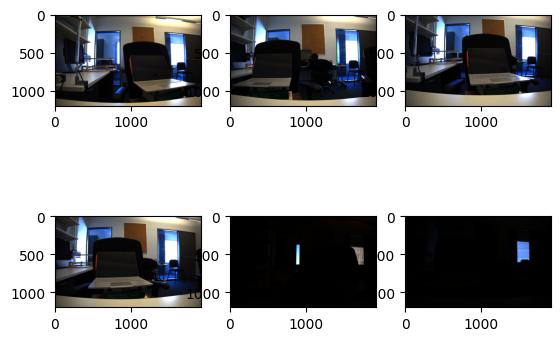

In [19]:
"""
// Demonstrates action commands
// (1) manually sets exposure, trigger and action command settings
// (2) prepares devices for action commands
// (3) synchronizes devices and fire action command
// (4) retrieves images with synchronized timestamps
"""

initial_vals_arr = []
for device in devices:
    # Get device stream nodemap
    tl_stream_nodemap = device.tl_stream_nodemap

    # Enable stream auto negotiate packet size
    tl_stream_nodemap['StreamAutoNegotiatePacketSize'].value = True

    # Enable stream packet resend
    tl_stream_nodemap['StreamPacketResendEnable'].value = True

    # Store initial values
    initial_vals = store_initial(device)
    initial_vals_arr.append(initial_vals)

synchronize_cameras()

print(f'{TAB1}Start stream')
for device in devices:
    device.start_stream()
"""
Compare timestamps
Scheduling action commands amongst PTP synchronized devices
results synchronized images with synchronized timestamps.
"""
schedule_action_command()

for i in range(0, devices.__len__()):
    restore_initial(initial_vals_arr.pop(0), devices[i])

print(f'{TAB1}Stop stream and destroy all devices')
system.destroy_device()


#### Save images as PNG
This version of schedule_action_commands saves each image as a PNG in the images folder

In [20]:
def schedule_action_command2():
    """
    Set up timing and broadcast action command
    Action commands must be scheduled for a time in the future.
    This can be done by grabbing the PTP time from a device, adding
    a delta to it, and setting it as an action command's execution time.
    """
    device = devices[0]
    imgs = []

    device.nodemap['PtpDataSetLatch'].execute()
    ptp_data_set_latch_value = device.nodemap['PtpDataSetLatchValue'].value

    print(f'{TAB2}Set action command to {DELTA_TIME_NS} nanoseconds from now')

    sys_tl_map['ActionCommandExecuteTime'].value \
        = ptp_data_set_latch_value + DELTA_TIME_NS

    print(f'{TAB2}Fire action command')
    """
    Fire action command
    Action commands are fired and broadcast to all devices, but
    only received by the devices matching desired settings.
    """
    sys_tl_map['ActionCommandFireCommand'].execute()

    
    pixel_format = PixelFormat.BGR8 # newglobal var to delete 
    count = 0
    # Grab image from cameras
    for device in devices:

        # Transfer Control
        device.nodemap['TransferStart'].execute()

        buffer = device.get_buffer(timeout=2000)

        device.nodemap['TransferStop'].execute()
        
        print(f'{TAB1}{TAB2}Received image from {device}'
              f' | Timestamp: {buffer.timestamp_ns} ns')
        
        
        #new code
        converted = BufferFactory.convert(buffer, pixel_format)
        print(f"{TAB1}Converted image to {pixel_format.name}")
        
        print(f'{TAB1}Prepare Image Writer')
        writer = Writer()
        writer.pattern = 'images/image_' + str(count) + '.jpg'
        
        writer.save(converted)
        print(f'{TAB1}Image saved')
        
        BufferFactory.destroy(converted)

        device.requeue_buffer(buffer)
        count += 1
        

In [21]:
"""
// Demonstrates action commands
// (1) manually sets exposure, trigger and action command settings
// (2) prepares devices for action commands
// (3) synchronizes devices and fire action command
// (4) retrieves images with synchronized timestamps
"""

initial_vals_arr = []
for device in devices:
    # Get device stream nodemap
    tl_stream_nodemap = device.tl_stream_nodemap

    # Enable stream auto negotiate packet size
    tl_stream_nodemap['StreamAutoNegotiatePacketSize'].value = True

    # Enable stream packet resend
    tl_stream_nodemap['StreamPacketResendEnable'].value = True

    # Store initial values
    initial_vals = store_initial(device)
    initial_vals_arr.append(initial_vals)

synchronize_cameras()

print(f'{TAB1}Start stream')
for device in devices:
    device.start_stream()
"""
Compare timestamps
Scheduling action commands amongst PTP synchronized devices
results synchronized images with synchronized timestamps.
"""
schedule_action_command2()

for i in range(0, devices.__len__()):
    restore_initial(initial_vals_arr.pop(0), devices[i])

print(f'{TAB1}Stop stream and destroy all devices')
system.destroy_device()


OSError: exception: access violation reading 0x0000000000000069